# Zadanie 4
## Optymalizacja metody akceptacji-odrzucenia

In [2]:
import random
import matplotlib.pyplot as plt
import numpy as np
import math
from scipy.stats import kstest
from scipy.stats.mstats import normaltest
from scipy.optimize import fmin, fminbound
from scipy.integrate import quad
import time
from scipy.stats import ks_2samp

plt.style.use('ggplot')

In [3]:
def generation(x_vector, a_vector, p_vector, m, value=1):
    if value == 1:
        x_n = x_vector[0]
        for i in range(1, len(x_vector) - 1):
            x_n += a_vector[i]*x_vector[i]**p_vector[i]
        return int(x_n % m)
    result = []
    for _ in range(value):
        x_n = x_vector[0]
        for i in range(1, len(x_vector) - 1):
            x_n += a_vector[i]*x_vector[i]**p_vector[i]
        x_n = int(x_n % m)
        result.append(x_n)
        for i in range(len(x_vector)-1):
            x_vector[i] = x_vector[i+1]
        x_vector[-1] = x_n
    
    return result

In [4]:
def uniform_generator(a=0, b=1, value=1):
    out = []
    m = 1/(5**(-303))
    a_vector = [m*2**87, m*3**64, m*5**76]
    p_vector = [0.05738, 1.5646, 1.23456]
    for _ in range(value):
        x_n = [time.clock()%400, time.clock() % 400, time.time()]
        if value == 1:
            return a + generation(x_n, a_vector, p_vector, m)/(m-1)*(b-a)
        out.append(a + generation(x_n, a_vector, p_vector, m)/(m-1)*(b-a))
    return out

In [5]:
def akceptacjaOdrzucenieCiagla(f, a, b, *args):
    M = f(fminbound(lambda x: -f(x, *args),a,b), *args)
    while True:
        u1 = uniform_generator(a,b)
        u2 = uniform_generator(0,M)
        if u2 <= f(u1, *args):
            return u1    

In [6]:
def generujAOC(f, a, b, n = 1000, *args):
    return [akceptacjaOdrzucenieCiagla(f, a, b, *args) for _ in range(n)]

In [7]:
def plotGestoscEmpiryczna(wyniki):
    plt.hist(wyniki, density = True)

In [8]:
def plotGestoscTeoretyczna(f, a, b, *args):
    x = np.linspace(a,b,100)
    y = [f(t, *args) for t in x]
    plt.plot(x, y)

In [9]:
def plotCDF(f, a, b, *args):
    zakres = np.linspace(a,b)
    wyniki = [quad(f,a,x, args = args)[0] for x in zakres]
    plt.plot(zakres,wyniki)

In [10]:
def testuj(f, a, b, *args, n = 1000):
    pierwszeWyniki = generujAOC(f, a, b, n, *args)
    
    plt.figure(figsize = (14,6))
    
    plt.subplot(1,2,1)
    plotGestoscEmpiryczna(pierwszeWyniki)
    plotGestoscTeoretyczna(f, a, b, *args)
    plt.title('Density')
    
    plt.subplot(1,2,2)
    plotECDF(pierwszeWyniki)
    plotCDF(f, a, b, *args)
    plt.title('ECDF vs. CDF')
    plt.show()
    
    print('Mean = ',np.mean(pierwszeWyniki))
    print('Std = ',np.std(pierwszeWyniki))

In [11]:
def optymalnyAO():
    M = 1/math.sqrt(3)
    while True:
        u1 = uniform_generator(0,math.pi)
        u2 = uniform_generator(0,M)
        if u2 <= f(u1):
            return u1 

In [12]:
def generujProbke(n = 10**4):
    return [optymalnyAO() for _ in range(n)]

In [13]:
def opt(n = 1000):
    M = math.ceil(math.sqrt(3))
    losoweU1 = np.array(uniform_generator(0, math.pi, M*n))
    losoweU2 = np.array(uniform_generator(0, 1/M, M*n))
    data = losoweU1[losoweU2 <= f(losoweU1)]
    length = len(data)
    if length >= n:
        return data[:n]
    else:
        toAppend = []
        print('Zabrakło')
        for _ in range(length - n):
            toAppend.append(optymalnyAO())
        return list(data).extend(toAppend)

In [14]:
def f(x):
    return 3*np.sin(x)*(np.cos(x))**2/2

In [15]:
def qqplot(data1, data2):
    x = list(range(1,99))
    percentile1 = np.percentile(data1,x)
    percentile2 = np.percentile(data2,x)
    plt.title("QQPlot")
    plt.plot(percentile1,percentile2)
    plt.plot([min(data1), max(data1)], [min(data2),max(data2)], '--', alpha = 0.5)

In [16]:
def testKS2samp(t = 100):
    good = 0
    alfa = 0.05
    for _ in range(t):
        data = opt(10**3)
        dataTeoretical = generujProbke(n = 10**3)
        p_value = ks_2samp(data, dataTeoretical)[1]
        if p_value >= alfa:
            good += 1
    return good/t

In [17]:
def testuj(data, f, a, b): 
    plt.figure(figsize = (14,6))
    
    plt.subplot(1,2,1)
    plotGestoscEmpiryczna(data)
    plotGestoscTeoretyczna(f, a, b)
    plt.title('Density')
    
    plt.subplot(1,2,2)
    dataTeoretical = generujProbke(n = 10**6)
    qqplot(data,dataTeoretical)
    
    plt.show()

# 1. Wstęp teoretyczny

Metoda akceptacji-odrzucenia jest to jedna z najbardziej podstawowych metod generowania zmiennych losowych o rozkładzie zadanym pewną funkcją gęstości. 

## Akceptacja-odrzucenie:
Chcemy wygenerwoać zmienną losową X o gęstości $f(x)$.

Założenia:
1. Potrafimy generować zmienną losową Y z rozkładu o gęstości g(x). X i Y przyjmują wartości z tego samego zbioru.
2. Potrafimy wyznaczyć stałą $c = \sup\limits_{x}\frac{f(x)}{g(x)}$.

Algorytm:
1. Generuj $Y$.
2. Generuj $U \sim U(0,1)$. $U$ jest niezależne z $Y$.
3. Jeśli $ U \leq \frac{f(Y)}{cg(Y)}$, to zwróć X = Y. W przeciwnym razie wróć do 1.



Celem tego zadania jest optymalizacj metody akceptacji-odrzucenia generowania zmiennej losowej z rozkładu o gęstości zadanej wzorem $f(x) = \frac{3}{2}sin(x)cos^2(x)$.  Wyznaczmy zatem stałą $c$ dla naszego przypadku.

**Lemat 1.** Dla rozkładu $f(x) = \frac{3}{2}sin(x)cos^2(x)$ opartego na rozkładzie jednostajnym $U(0,\pi)$ stała c wynosi $\frac{\pi}{\sqrt{3}}$.

**Dowód:** Przypomnijmy, że gęstość rozkładu jednostajnego $U(0,\pi)$ wynosi $g(x) = \frac{1}{\pi}$ dla $x\in[0,\pi]$

Musimy zatem policzyć 
$$ c = \sup\limits_{x}\frac{\frac{3}{2}sin(x)cos^2(x)}{\frac{1}{\pi}}  = \sup\limits_{x}\frac{3\pi sin(x)cos^2(x)}{2} = \dots $$

Jako sprytni studenci skorzystaliśmy z wiedzy tajemnych magów spod znaku Wolfram:

https://www.wolframalpha.com/input/?i=supremum+of+3pisin(x)cos%5E2(x)%2F2

i otrzymaliśmy, że:

$$ ... = \frac{\pi}{\sqrt{3}} $$

Posiadają powyższą wiedzę możemy uprościć nasz algorytm i dostosować do naszych potrzeb.

$$\frac{f(Y)}{cg(Y)} = \frac{f(Y)}{\frac{\pi}{\sqrt{3}}\frac{1}{\pi}} = \sqrt{3}f(Y)$$

Zatem $ U \leq  \sqrt{3}f(Y) $, czyli możemy zapisać, że $\frac{U}{\sqrt{3}} \leq f(Y)$. A zatem ostatecznie $Z \leq f(Y)$, gdzie $ Z \sim U(0,\frac{1}{\sqrt{3}})$.

Ostateczny algorytm:

1. Generuj $Y \sim U(0,\pi)$.
2. Generuj $Z \sim U(0,\frac{1}{\sqrt{3}})$.
3. Jeżeli $ Z \leq f(Y) $, to zwróć X = Y. W przeciwnym razie wróć do 1.

__Lemat 2.__ Jeśli $U$ jest zmienną losową o rozkładzie $U(0,1)$, to zmienna losowa $V=U^n$ ma rozkład $B(\frac{1}{n},1)$._

__Dowód:__
Niech $U \sim U(0,1)$ oraz $V=U^n$. Chcemy pokazać, że $ V \sim B(\frac{1}{n},1)$. Przypomnijmy zatem postać gestości rozkładu $B(\alpha,\beta)$:
$$f(x) = \frac{x^{\alpha-1}(1-x)^{\beta-1}} {B(\alpha,\beta)}\!,$$
gdzie $B(\alpha,\beta) = \frac{\Gamma(\alpha)\Gamma(\beta)}{\Gamma(\alpha + \beta)}$.


W naszym przypadku gęstość przyjmie postać:
$$f(x) = \frac{x^{\frac{1}{n}-1}} {B(\frac{1}{n},1)},$$

Ale $B(\frac{1}{n},1) = \frac{(\frac{1}{n} - 1)!(1-1)!}{(\frac{1}{n} + 1 - 1)!} = \frac{(\frac{1}{n} - 1)!}{(\frac{1}{n})!} = \frac{(\frac{1}{n} - 1)!}{(\frac{1}{n} - 1)!\frac{1}{n}} = n $

Zatem ostatecznie nasza gęstość przyjmie postać:

$$f(x) = \frac{x^{\frac{1}{n}-1}} {n}$$

Policzmy zatem $F_V(v)$:

$$F_V(v) = P(V<v) = P(U^n<v) = P(U<\sqrt[n]{v}) = F_U(\sqrt[n]{v})$$

Stąd:

$$f_V(v) = F^{\prime}_{V}(v) = F^{\prime}_{U}(\sqrt[n]{v}) = \frac{v^{\frac{1}{n} -1}}{n}$$

Zatem $ V \sim B(\frac{1}{n},1)$.

__Dwustronny test Kołmogorova-Smirnova__ 

Jest to test analogiczny do opisanego w zadaniu 3 testu Kołmogorova-Smirnova(jednostronnego). Różnica polega na tym, że zamiast dystrybuanty teoretycznej bierzemy dystrybuantę empiryczną drugiego zestawu danych.


# 2. Problem badawczy
Wyjściowym algorytmem, który będziemy optymalizować jest algorytm z zadania 10, którego kod znajduje się powyżej. Jedną z metod optymalizacji algorytmu jest znalezienie takiego nośnika prawdopodobieństwa, na którym będzie bazować, aby stała c, była jak najmniejsza. Inną z metod jest wykorzystanie specyfiki danego języka i optymalizacja struktury danych, na której operujemy. 

# 3. Wyniki

Nasze próby optymalizacji algorytmu rozpoczęliśmy od znalezienia rozkładu, którego gęstość jest podobna do naszej wyjściowej gęstości. Po dłuższych próbach sztuka ta udała się, lecz wstępne wyniki badań szybkości algorytmu były tak słabe, że nie przytaczamy tego rozwiązania w tym sprawozdaniu. Metodą, na której się skupimy, będzie wykorzystanie specyfiki języka *Python* oraz wykorzystanie biblioteki *NumPy*, która zapewnia nam operacje na macierzach.

Zmierzmy czas generowania $10^4$ zmiennych losowych z tego rozkładu:

In [18]:
start = time.time()
data = generujAOC(f, 0, math.pi, 10**4)
print('Czas generowania z wyjściowego algorytmu:', time.time() - start)

start = time.time()
data = generujProbke(10**4)
print('Czas generowania z wstawionym M:', time.time() - start)

start = time.time()
data = opt(10**4)
print('Czas generowania z optymalizacją:', time.time() - start)

Czas generowania z wyjściowego algorytmu: 2.589604616165161
Czas generowania z wstawionym M: 0.14039993286132812
Czas generowania z optymalizacją: 0.10920023918151855


Widzimy znaczną poprawę działania algorytmu po wstawieniu odpowiedniego $c$ do algorytmu.

Sprawdźmy zatem jaki średni czas ma nasz algorytm na próbce o rząd większej:

In [19]:
czasy = []
for _ in range(10):
    start = time.time()
    opt(10**5)
    czasy.append(time.time() - start)
print(np.mean(czasy))

0.848641490936


Sprawdzamy jeszcze poprawność generowanych liczb na histogramie oraz na QQPlot generowanym przez próbki z rozkładu zoptymalizowanego z rozkładem wyjściowym z zajęć. Ponadto wykorzystujemy dwustronny test Kołmogorowa-Smirnova z poziomem istotności $\alpha=0.05$ do sprawdzenia, czy próbki faktycznie pochodzą z tych samych rozkładów.

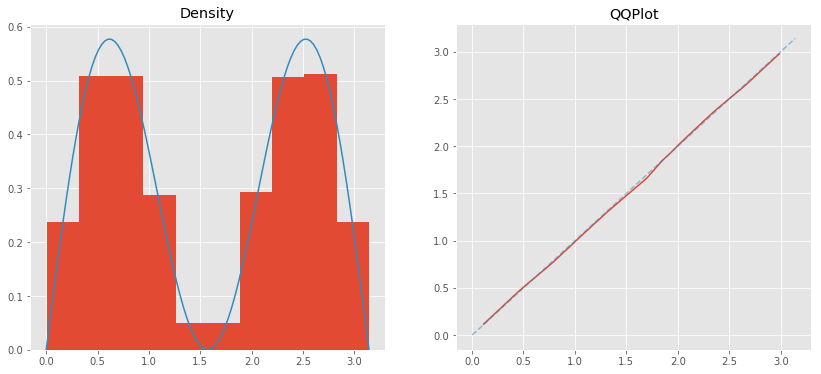

In [20]:
data = opt(10**5)

testuj(data, f, 0, math.pi)

In [21]:
testKS2samp()

0.94

Z powyższych wyników możemy uznać, że algorytmy generują ten sam rozkład. Jedynie możemy zauważyć, że pojawiają się pewne odstępstwa dla liczb w okolicach 1.5, gdzie gęstość przyjmuje wartości bliskie 0. Natomiast test statystyczny potwierdził, że te różnice są statystycznie nieistotne.

Jako ciekawostkę chcielibyśmy dodać, że korzystając z wbudowanej w bibliotece *numpy* funkcji generującej całą listę liczb pseudolosowych udało nam się uzyskać czas ok. 0.2s dla próbki o długości $10^6$